In [31]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from service_defs import *
import torch.functional as F
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
import collections
from tqdm import tqdm
from libs.SGDR_Restarts_Warmup import CosineAnnealingWarmupRestarts
import os, shutil, threading
from sklearn.utils import shuffle
from libs.ewma import *
from libs.nn_classes import *
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler

from path import *

In [54]:
batch_size = 1000
epochs = 96

if torch.cuda.is_available():
    print(f'CUDA device: {torch.cuda.get_device_name()}')
    print(torch.cuda.get_device_properties("cuda"))
    DEVICE = torch.device("cuda")
else:
    print('CUDA not available')
    DEVICE = torch.device("cpu")

CUDA device: NVIDIA GeForce GTX 1650
_CudaDeviceProperties(name='NVIDIA GeForce GTX 1650', major=7, minor=5, total_memory=4096MB, multi_processor_count=16)


In [55]:
# get full dataset
ds_fnames = find_files('./../clouds_databases', 'dataset-*.csv')
dfs = [pd.read_csv(fn, sep=',', decimal='.', parse_dates=['photo_time', 'data time']) for fn in ds_fnames]
df = pd.concat(dfs)

# filter some low vals of radiation
df = df[df['CM3up[W/m2]'] >= 5.0]

# to apply splitting by hours add column with hour of photo taking 
df['date-hour'] = df.photo_time.apply(lambda dt: str(dt.date())+'-'+('%02d'%dt.hour))
dates = np.unique(df['date-hour'])

feature_columns = [c for c in df.columns if c.startswith('f')]

df.shape

(314066, 171)

In [56]:
# split dataset
dates_train, dates_val = train_test_split(dates, test_size=0.25)

ytr = df[df['date-hour'].isin(dates_train)]['CM3up[W/m2]'].values
yval = df[~df['date-hour'].isin(dates_train)]['CM3up[W/m2]'].values

Xtr = df[df['date-hour'].isin(dates_train)][feature_columns].values
Xval = df[~df['date-hour'].isin(dates_train)][feature_columns].values

# normalize data
X_scaler = StandardScaler()
y_scaler = StandardScaler()

X_scaler.fit(Xtr)
y_scaler.fit(ytr.reshape((-1,1)))

Xtr = X_scaler.transform(Xtr)
ytr = y_scaler.transform(ytr.reshape((-1,1)))
Xval = X_scaler.transform(Xval)
yval = y_scaler.transform(yval.reshape((-1,1)))

# prepare
ds_tr = DS(Xtr, ytr)
ds_val = DS(Xval, yval)

#prepare bathes
dataloader_train = DataLoader(ds_tr, batch_size=batch_size)
dataloader_val = DataLoader(ds_val, batch_size=batch_size)



In [80]:
# define neural network
class MLP(torch.nn.Module):
    def __init__(self, in_features):
        super(MLP, self).__init__()
        l1 = nn.Linear(in_features, 512)
        act1 = nn.LogSigmoid()
        l2 = nn.Linear(512, 512)
        act2 = nn.LogSigmoid()
        l3 = nn.Linear(512, 512)
        act3 = nn.LogSigmoid()
        l4 = nn.Linear(512, 1)
#         act4 = nn.LogSigmoid()
        self.layers = nn.ModuleList([l1, act1, l2, act2, l3, act3, l4,])
    
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

In [81]:
model = MLP(in_features=Xtr.shape[1]).to(DEVICE)

optimizer = optim.Adam(model.parameters(), lr=1e-4)

scheduler = CosineAnnealingWarmupRestarts(optimizer,
                                          first_cycle_steps = 32,
                                          cycle_mult=2,
                                          max_lr = 1e-4,
                                          min_lr = 1e-8,
                                          warmup_steps=0,
                                          gamma=0.7,
                                          last_epoch=-1)

loss_fn = MSE()

loss_hist = []
epoch_loss_hist = []
val_loss_hist = []

In [82]:
for epoch_num in range(epochs):
    epoch_loss = []
    
    pbar = tqdm(total=len(dataloader_train))
    pbar.set_description('epoch: %04d' % epoch_num)
    for iter_num, (x_batch, y_batch) in enumerate(dataloader_train):
        optimizer.zero_grad()
        y_pred = model(x_batch.to(DEVICE).float())
        loss = loss_fn(y_pred, y_batch.to(DEVICE).float())
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 0.1)
        optimizer.step()
        batch_loss_value = float(loss)
        loss_hist.append(batch_loss_value)
        epoch_loss.append(batch_loss_value)
        pbar.update(1)

        # loss_sm = ewma_safe(np.array(loss_hist), alpha=0.6)
        # pbar.set_postfix({'loss': loss_sm[-1]})
    epoch_loss_hist.append(np.mean(epoch_loss))
    pbar.close()
    scheduler.step()
    
    model.train(False)
    
    val_loss_epoch = []
    pbar = tqdm(total=len(dataloader_val))
    pbar.set_description('validation. epoch: %04d' % epoch_num)
    for iter_num, (x_batch, y_batch) in enumerate(dataloader_val):
        y_pred = model(x_batch.to(DEVICE).float())
        loss = loss_fn(y_pred, y_batch.to(DEVICE).float())
        batch_loss_value = float(loss)
        val_loss_epoch.append(batch_loss_value)
        pbar.update(1)
    val_loss_hist.append(np.mean(val_loss_epoch))
    pbar.set_postfix({'val_loss': val_loss_hist[-1]})
    pbar.close()
    
    model.train(True)

validation. epoch: 0095: 100%|█████████████████████████████████████████| 79/79 [00:00<00:00, 90.32it/s, val_loss=0.116]


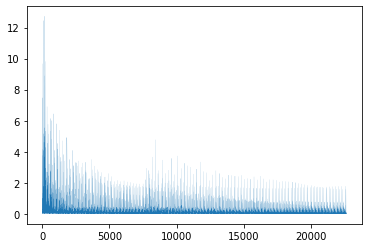

In [83]:
plt.plot(loss_hist, linewidth=0.1)

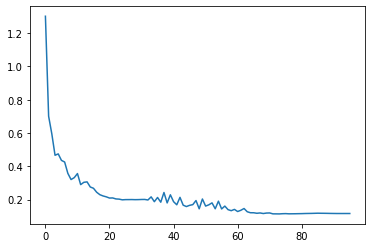

In [84]:
plt.plot(val_loss_hist)

In [85]:
ds_test = DS(Xval, yval)
dataloader_test = DataLoader(ds_test, batch_size=batch_size)

model.train(False)

devs = []
pbar = tqdm(total=len(dataloader_test))
targets = []
y_preds = []
for iter_num, (x_batch, y_batch) in enumerate(dataloader_test):
    x = model(x_batch.to(DEVICE).float())
    targets.append(y_batch.detach().cpu().numpy())
    y_preds.append(x.detach().cpu().numpy())
    dev = x-y_batch.to(DEVICE).float()
    devs.append(dev.detach().cpu().numpy())
    pbar.update(1)
pbar.close()

100%|██████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 99.64it/s]


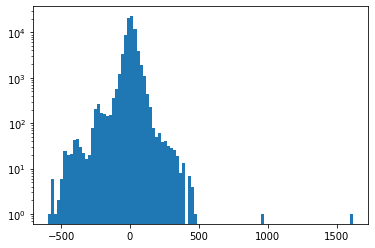

In [86]:
devs = np.concatenate(devs)

targets = np.concatenate(targets)
y_preds = np.concatenate(y_preds)

targets = y_scaler.inverse_transform(targets)
y_preds = y_scaler.inverse_transform(y_preds)

devs = y_preds-targets

_ = plt.hist(devs, bins=100)
plt.yscale('log')

(-45.029816350000004, 1056.12758935, -119.52234282493592, 2330.914242887497)

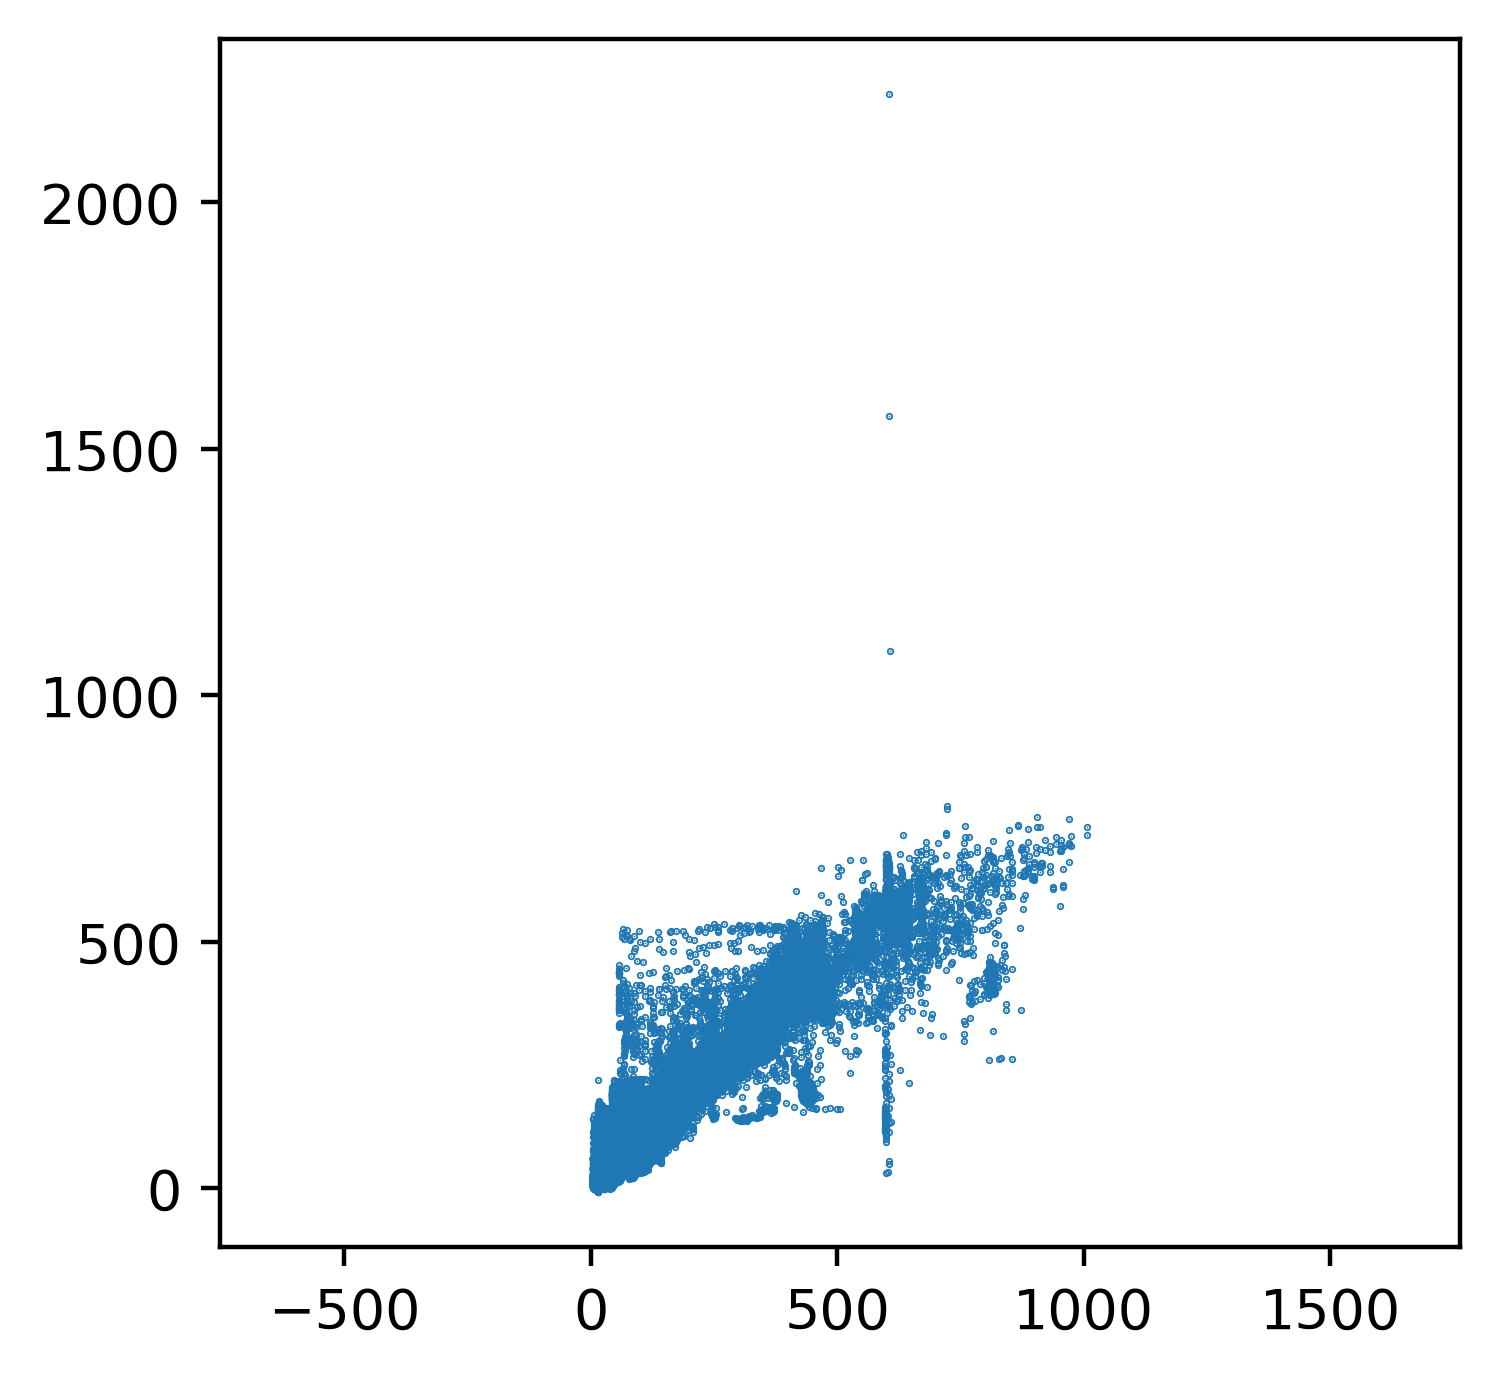

In [92]:
f = plt.figure(figsize=(4,4), dpi=400)
plt.scatter(targets, y_preds, s=0.1)
plt.axis('equal')

In [88]:
np.sqrt(np.mean(np.square(devs)))

53.46952960486566